### CS613 Final Project
### Notebook 1: Pre-processing
### Submitted by: John Obuch, Fatih Catpinar, Meghan Colosimo, Colin Murphy
### 3/19/20

In [1]:
#Requirements
#NOTE: Must pip install imblearn in terminal first!

import time, pandas as pd, numpy as np
start_time = time.time()
from collections import Counter, defaultdict
from pprint import pprint
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
import re
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

## Data Acquisition

1) Behavioral Risk Factor Surveillance System (BRFSS) survey data is published annually, the data is avaliable via the following page:

https://www.cdc.gov/brfss/annual_data/annual_data.htm

2) To download the data, select a specific year. It will land to the the year page.

3) Scroll down to "Data Files". The data files are provided in ASCII and SAS Transport formats.

4) Dowload the appropriate file type. For this study we will use "SAS Transport Format."

## Data Documentation

- To learn more information about the survey for specific year, read the files under "Survey Data Information". <br/>
Check the codebook, to see variable names, location, and frequency of values for all reporting areas <br/>
combined for the combined landline and cell phone data set.

2017 Survey Codebook
https://www.cdc.gov/brfss/annual_data/2017/pdf/codebook17_llcp-v2-508.pdf

2018 Survey Codebook
https://www.cdc.gov/brfss/annual_data/2018/pdf/codebook18_llcp-v2-508.pdf

- BRFSS Survey Questions
https://www.cdc.gov/brfss/questionnaires/index.htm

## Our plan

Dowloaded 2017 and 2018 survey data in SAS Transport format. 

https://www.cdc.gov/brfss/annual_data/annual_2017.html

https://www.cdc.gov/brfss/annual_data/annual_2018.html

Unzipped the data and placed the data files are in the "data" folder.

The name of the survey data are: 
- LLCP2017.XPT
- LLCP2018.XPT

We will use the above data to create several models.

## Loading the data

In [2]:
# read data as a pandas dataframe. Note: This process will take time

df_2017 = pd.read_sas('data/LLCP2017.XPT')
df_2018 = pd.read_sas('data/LLCP2018.XPT')

run_time = time.time() - start_time
print('run_time:\n', run_time)

run_time:
 110.07133102416992


## Exploring the Data

In [3]:
# take a look at data

df_2017.head()

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENM1,...,_PA300R2,_PA30021,_PASTRNG,_PAREC1,_PASTAE1,_RFSEAT2,_RFSEAT3,_FLSHOT6,_PNEUMO2,_AIDTST3
0,1.0,1.0,b'01302017',b'01',b'30',b'2017',1100.0,b'2017000001',2.017000e+09,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,b'01122017',b'01',b'12',b'2017',1100.0,b'2017000002',2.017000e+09,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,b'01102017',b'01',b'10',b'2017',1100.0,b'2017000003',2.017000e+09,1.0,...,3.0,2.0,2.0,4.0,2.0,1.0,1.0,1.0,1.0,2.0
3,1.0,1.0,b'02082017',b'02',b'08',b'2017',1200.0,b'2017000004',2.017000e+09,1.0,...,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,NaN
4,1.0,1.0,b'01302017',b'01',b'30',b'2017',1100.0,b'2017000005',2.017000e+09,1.0,...,3.0,2.0,2.0,4.0,2.0,1.0,2.0,2.0,2.0,2.0


In [4]:
#df_2018.head()

In [5]:
# the shape of the data

print('The shape of the 2017 data is:', df_2017.shape)
print('In 2017', df_2017.shape[0], 'took the survey and there were', df_2017.shape[1], 
      'features in the original 2017 dataset.\n')

print('The shape of the 2018 data is:', df_2018.shape)
print('In 2018', df_2018.shape[0], 'took the survey and there were', df_2018.shape[1], 
      'features in the original 2018 dataset.')

The shape of the 2017 data is: (450016, 358)
In 2017 450016 took the survey and there were 358 features in the original 2017 dataset.

The shape of the 2018 data is: (437436, 275)
In 2018 437436 took the survey and there were 275 features in the original 2018 dataset.


In [6]:
#check data types - categorical data is being interpreted as numeric data, so dummy coding is required

print(Counter(df_2017.dtypes))
print(Counter(df_2018.dtypes))

Counter({dtype('float64'): 352, dtype('O'): 6})
Counter({dtype('float64'): 269, dtype('O'): 6})


In [7]:
# we can print the columns of the data
# check the codebook for detailed information about the column

#df_2017.columns
#df_2018.columns

In [8]:
# answer counts to features
# it counts non-empty cells

#df_2017.count()
#df_2018.count()

In [9]:
# descriptive statistics

#df_2017.describe()
#df_2018.describe()

## Part 1: Data Preprocessing

- Scales are diffent, we need to standardize the (continuous) features.
- Convert categorical data to dummy variables.
- Handle missing information.
For example; in a binary Yes/No question. There may be 5 possible answers in this survey:
    - 1 Yes
    - 2 No
    - 7 Don’t know/Not Sure
    - 9 Refused
    - BLANK Not asked or Missing

- Reenginner the answers so that direction is consistent (e.g., reverse-coded variables). (Ex: Poor:5, Excellent:1)
- Address imbalanced cases of outcome variable with SMOTE.
- NOTE: There are some questions asked in specific states.

### Preprocessing Plan:

<b>Part 1A: Drop columns that are:

- Features related to metadata (e.g., interview details, filters, etc.)
- Open-ended response data (strings)
- Unscaled continuous features (e.g., in days, hours, or weeks)
- Redundant features (e.g., height in meters)
- Redundant outcomes (e.g., multiple versions of the question 'Have you ever been diagnoised with X disease?')

In [10]:
#Names of columns to drop for the 2017 dataset

metadata_features = ['IDATE', 'IMONTH', 'IDAY', 'IYEAR', 'SEQNO', 'FMONTH', 'DISPCODE', '_PSU', 'SAFETIME', 'QSTVER', 
                     '_STSTR', '_STRWT', '_RAWRAKE', '_WT2RAKE', '_CLLCPWT', '_DUALUSE', '_DUALCOR', '_LLCPWT2', '_LLCPWT',
                    '_FRUITE1', '_VEGETE1', 'PAMISS1_']

openended_features = ['DLYOTHER']

#Scaled versions of these varaibles already exist in the dataset - drop the unscaled, redundant data
unscaled_features = ['WEIGHT2', 'HEIGHT3', 'ALCDAY5', 'AVEDRNK2', 'DROCDY3_', 'FRUIT2', 'FRUITJU2', 'FVGREEN1', 'POTATOE1',
                    'VEGEDA2_', 'EXEROFT1', 'EXEROFT2', 'STRENGTH', 'FRENCHF1', 'VEGETAB2']

# NOTE: There are multiple columns representing the same data for a subset of features (e.g., race, age)
# The majority of these redundicies will be addressed with PCA.

redundant_features = ['HTM4']

#NOTE: These features need to be dropped from the X data before training the model

redundant_outcomes = ['BPHIGH4', 'TOLDHI2', 'CVDINFR4', 'CVDCRHD4', 'ASTHMA3',  'ASTHNOW', 'HAVARTH3']

print('The number of pre-selected columns to drop is:', len(metadata_features) + len(openended_features) + len(unscaled_features) +
     len(redundant_features) + len(redundant_outcomes))

The number of pre-selected columns to drop is: 46


In [11]:
#Dropping pre-selected columns

df_2017.drop(columns = metadata_features, inplace = True)
df_2017.drop(columns = openended_features, inplace = True)
df_2017.drop(columns = unscaled_features, inplace = True)
df_2017.drop(columns = redundant_features, inplace = True)
df_2017.drop(columns = redundant_outcomes, inplace = True)

print('The dataframe is the expected shape after dropping pre-selected columns:', df_2017.shape[1] == 358 - 46)

The dataframe is the expected shape after dropping pre-selected columns: True


<b>Part 1B: Determine which variables are continuous or categorical for proper pre-processing:

In [12]:
# Continuous Features (based on documentation)

countinuous_features_17 = ['NUMMEN', 'NUMADULT', 'NUMWOMEN', 'HHADULT', 'PHYSHLTH', 'MENTHLTH', 'POORHLTH', 'DIABAGE2',
                            'JOINPAI1', 'NUMPHON2', 'CHILDREN', 'WEIGHT2', 'HEIGHT3', 'ALCDAY5', 'AVEDRNK2', 'DRNK3GE5',
                          'MAXDRNKS', 'FRUIT2', 'FRUITJU2', 'FVGREEN1', 'POTATOE1', 'EXEROFT1',
                          'EXERHMM1', 'EXEROFT2', 'EXERHMM2', 'STRENGTH', 'BLDSUGAR', 'FEETCHK2', 'DOCTDIAB', 'CHKHEMO3',
                           'FEETCHK', 'COPDSMOK', 'ASTHMAGE', 'ASDRVIST', 'ASRCHKUP', 'ASACTLIM', 'PAINACT2', 'QLMENTL2',
                          'QLHLTH2', 'SLEPTIM1', 'ADSLEEP', 'SLEPDAY1', 'DRVISITS', 'CNCRAGE', 'SSBSUGR2','SSBFRUT3', 
                          'MARIJANA', 'HPVADSHT', 'LCSFIRST', 'LCSLAST', 'LCSNUMCG', 'SDHMOVE', 'HTIN4', 'WTKG3', '_DRNKWEK',
                          'DROCDY3_', 'FTJUDA2_', 'FRUTDA2_', 'GRENDA1_', 'FRNCHDA_', 'POTADA1_', 'VEGEDA2_', 'METVL11_',
                          'METVL21_', 'MAXVO2_', 'FC60_', 'PADUR1_', 'PADUR2_', 'PAFREQ1_', 'PAFREQ2_', 'STRFREQ_', '_MINAC11',
                          '_MINAC21', 'PAMIN11_', 'PAMIN21_', 'PA1MIN_', 'PAVIG11_', 'PAVIG21_', 'PA1VIGM_', '_FRUTSU1',
                          '_VEGESU1', 'FLSHTMY2', '_BMI5', '_AGE80']

In [13]:
# Categorical Features

categorical_features_17 = [col_name for col_name in df_2017.columns if col_name not in countinuous_features_17]

pprint(categorical_features_17)

['_STATE',
 'CTELENM1',
 'PVTRESD1',
 'COLGHOUS',
 'STATERE1',
 'CELLFON4',
 'LADULT',
 'CTELNUM1',
 'CELLFON5',
 'CADULT',
 'PVTRESD3',
 'CCLGHOUS',
 'CSTATE1',
 'LANDLINE',
 'GENHLTH',
 'HLTHPLN1',
 'PERSDOC2',
 'MEDCOST',
 'CHECKUP1',
 'BPMEDS',
 'CHOLCHK1',
 'CHOLMED1',
 'CVDSTRK3',
 'CHCSCNCR',
 'CHCOCNCR',
 'CHCCOPD1',
 'ADDEPEV2',
 'CHCKIDNY',
 'DIABETE3',
 'LMTJOIN3',
 'ARTHDIS2',
 'ARTHSOCL',
 'SEX',
 'MARITAL',
 'EDUCA',
 'RENTHOM1',
 'NUMHHOL2',
 'CPDEMO1A',
 'VETERAN3',
 'EMPLOY1',
 'INCOME2',
 'INTERNET',
 'PREGNANT',
 'DEAF',
 'BLIND',
 'DECIDE',
 'DIFFWALK',
 'DIFFDRES',
 'DIFFALON',
 'SMOKE100',
 'SMOKDAY2',
 'STOPSMK2',
 'LASTSMK2',
 'USENOW3',
 'ECIGARET',
 'ECIGNOW',
 'EXERANY2',
 'EXRACT11',
 'EXRACT21',
 'SEATBELT',
 'FLUSHOT6',
 'PNEUVAC3',
 'SHINGLE2',
 'HIVTST6',
 'HIVTSTD3',
 'HIVRISK5',
 'PDIABTST',
 'PREDIAB1',
 'INSULIN',
 'EYEEXAM',
 'DIABEYE',
 'DIABEDU',
 'COPDCOGH',
 'COPDFLEM',
 'COPDBRTH',
 'COPDBTST',
 'HAREHAB1',
 'STREHAB1',
 'CVDASPRN',
 'ASPUNSAF'

<b>Part 1C: Rescale variables for consistency:

Categorical Variables:
- Possible values for all outcomes should be 0 = No dx, 1 = Yes dx

Continuous Variables:
- Rescale variables w/ multiple units of measurement (e.g., in days, hours, weeks) that were not previously dropped (e.g., SSBSUGR2, SSBFRUT3)
- <i>Note: Rescaling continuous variables was ultimately not required because all remaining unscaled columns were later dropped due to high missigness

#### Rescaling Categorical Variables:

In [14]:
# Partial Scaled Outcome Variables:

# Possible Values vary by variable (see below)
# Grouped according to coding schema for recoding

# _RFHYPE5 = High blood presure (1 = No, 2 = Yes, 9 = Don't Know/Not Sure/Refused/Missing)
# _RFCHOL1 = High Cholesterol (1 = No, 2 = Yes, Blank = Don't Know/Not Sure/Refused/Missing)
# _MICHD = Coronary heart disease/myocardial infarction (1 = Yes, 2 = No, 9 = Don't Know/Not Sure/Refused/Mising)
# _LTASTH1 = Lifetime asthma (1 = No, 2 = Yes, 9 = Don't Know/Not Sure/Resfued/Missing)
# _DRDXAR1 = Arthritis d/x (1 = Yes, 2 = No, Blank = Don't Know/Not Sure/Refused/Missing)

partial_scaled_outcome_vars1 = ['_RFHYPE5', '_RFCHOL1', '_DRDXAR1'] 

print('The original value counts before recoding:\n')
pprint([df_2017[col_name].value_counts() for col_name in partial_scaled_outcome_vars1])

print('The NaN counts before reocoding:\n')
pprint([df_2017[col_name].isna().sum() for col_name in partial_scaled_outcome_vars1])

The original value counts before recoding:

[1.0    267519
2.0    181098
9.0      1399
Name: _RFHYPE5, dtype: int64,
 1.0    241794
2.0    156651
Name: _RFCHOL1, dtype: int64,
 2.0    299934
1.0    147288
Name: _DRDXAR1, dtype: int64]
The NaN counts before reocoding:

[0, 51571, 2794]


In [15]:
partial_scaled_outcome_vars1_mapper = {1.0 : 0, 2.0 : 1, 9.0: np.NaN} #1 = No, 2 = Yes

for column in partial_scaled_outcome_vars1:
    df_2017[column] = df_2017[column].map(partial_scaled_outcome_vars1_mapper)
    
print('The new value counts after recoding:\n')
pprint([df_2017[col_name].value_counts() for col_name in partial_scaled_outcome_vars1])

print('The NaN counts after recoding:\n')
pprint([df_2017[col_name].isna().sum() for col_name in partial_scaled_outcome_vars1])

The new value counts after recoding:

[0.0    267519
1.0    181098
Name: _RFHYPE5, dtype: int64,
 0.0    241794
1.0    156651
Name: _RFCHOL1, dtype: int64,
 1.0    299934
0.0    147288
Name: _DRDXAR1, dtype: int64]
The NaN counts after recoding:

[1399, 51571, 2794]


In [16]:
partial_scaled_outcome_vars2 = ['_MICHD', '_LTASTH1',]

print('The original value counts before recoding:\n')
pprint([df_2017[col_name].value_counts() for col_name in partial_scaled_outcome_vars2])

print('The NaN counts before reocoding:\n')
pprint([df_2017[col_name].isna().sum() for col_name in partial_scaled_outcome_vars2])

The original value counts before recoding:

[2.0    406515
1.0     39357
Name: _MICHD, dtype: int64,
 1.0    386142
2.0     62411
9.0      1463
Name: _LTASTH1, dtype: int64]
The NaN counts before reocoding:

[4144, 0]


In [17]:
partial_scaled_outcome_vars2_mapper = {2.0 : 0, 1.0 : 1, 9.0: np.NaN}  #1 = Yes, 2 = No

for column in partial_scaled_outcome_vars2:
    df_2017[column] = df_2017[column].map(partial_scaled_outcome_vars2_mapper)
    
print('The new value counts after recoding:\n')
pprint([df_2017[col_name].value_counts() for col_name in partial_scaled_outcome_vars2])

print('The NaN counts after recoding:\n')
pprint([df_2017[col_name].isna().sum() for col_name in partial_scaled_outcome_vars2])

The new value counts after recoding:

[0.0    406515
1.0     39357
Name: _MICHD, dtype: int64,
 1.0    386142
0.0     62411
Name: _LTASTH1, dtype: int64]
The NaN counts after recoding:

[4144, 1463]


In [18]:
# Unscaled Outcome Variables:

# Possible Values: 1 = Yes, 2 = No, 7 = Don't Know/Not Sure, 9 = Refused, Blank = Not Asked/Missing

# CVDSTRK3 = Stroke
# CHCSCNCR = Skin Cancer
# CHCOCNCR = Other Cancer
# ADDEPEV2 = Depressive Disorder
# CHCKIDNY = Chronic Kidney Disease

unscaled_outcome_vars1 = ['CVDSTRK3', 'CHCSCNCR', 'CHCOCNCR', 'CHCCOPD1', 'ADDEPEV2', 'CHCKIDNY']

print('The original value counts before recoding:\n')
pprint([df_2017[col_name].value_counts() for col_name in unscaled_outcome_vars1])

print('The NaN counts before reocoding:\n')
pprint([df_2017[col_name].isna().sum() for col_name in unscaled_outcome_vars1])

The original value counts before recoding:

[2.0    429710
1.0     18956
7.0      1200
9.0       148
Name: CVDSTRK3, dtype: int64,
 2.0    406161
1.0     42661
7.0      1027
9.0       165
Name: CHCSCNCR, dtype: int64,
 2.0    404637
1.0     44289
7.0       867
9.0       220
Name: CHCOCNCR, dtype: int64,
 2.0    410141
1.0     37577
7.0      2099
9.0       197
Name: CHCCOPD1, dtype: int64,
 2.0    358683
1.0     89209
7.0      1661
9.0       460
Name: ADDEPEV2, dtype: int64,
 2.0    430890
1.0     17547
7.0      1368
9.0       208
Name: CHCKIDNY, dtype: int64]
The NaN counts before reocoding:

[2, 2, 3, 2, 3, 3]


In [19]:
unscaled_outcome_vars1_mapper = {1.0 : 1, 2.0 : 0, 7.0: np.NaN, 9.0: np.NaN} #1 = Yes, 2 = No, 7 = Don't Know/Not Sure, 9 = Refused, Blank = Not Asked/Missing

for column in unscaled_outcome_vars1:
    df_2017[column] = df_2017[column].map(unscaled_outcome_vars1_mapper)
    
print('The new value counts after recoding:\n')
pprint([df_2017[col_name].value_counts() for col_name in unscaled_outcome_vars1])

print('The NaN counts after recoding:\n')
pprint([df_2017[col_name].isna().sum() for col_name in unscaled_outcome_vars1])

The new value counts after recoding:

[0.0    429710
1.0     18956
Name: CVDSTRK3, dtype: int64,
 0.0    406161
1.0     42661
Name: CHCSCNCR, dtype: int64,
 0.0    404637
1.0     44289
Name: CHCOCNCR, dtype: int64,
 0.0    410141
1.0     37577
Name: CHCCOPD1, dtype: int64,
 0.0    358683
1.0     89209
Name: ADDEPEV2, dtype: int64,
 0.0    430890
1.0     17547
Name: CHCKIDNY, dtype: int64]
The NaN counts after recoding:

[1350, 1194, 1090, 2298, 2124, 1579]


In [20]:
unscaled_outcome_vars2 = ['DIABETE3']

print('The original value counts before recoding:\n')
print(df_2017['DIABETE3'].value_counts())

print('The NaN counts before reocoding:', df_2017['DIABETE3'].isna().sum())

The original value counts before recoding:

3.0    377264
1.0     60440
4.0      8232
2.0      3283
7.0       594
9.0       199
Name: DIABETE3, dtype: int64
The NaN counts before reocoding: 4


In [21]:
# Possible Values for DIABETE3 only: 1 = Yes, 2 = Yes but told during pregnancy, 3 = No, 4 = No (pre-diabetes or borderline),
# 7 = Don't know/Not Sure, 9 = Refused, Blank = Missing

unscaled_outcome_vars2_mapper = {1.0 : 1, 2.0 : 1, 3.0: 0, 4.0: 0, 7.0: np.NaN, 9.0: np.NaN}

df_2017['DIABETE3'] = df_2017['DIABETE3'].map(unscaled_outcome_vars2_mapper)
    
print('The new value counts after recoding:\n')
print(df_2017['DIABETE3'].value_counts())

print('The NaN counts after reocoding:', df_2017['DIABETE3'].isna().sum())

The new value counts after recoding:

0.0    385496
1.0     63723
Name: DIABETE3, dtype: int64
The NaN counts after reocoding: 797


In [22]:
all_possible_outcomes = partial_scaled_outcome_vars1 + partial_scaled_outcome_vars2 + unscaled_outcome_vars1 + unscaled_outcome_vars2

pprint(all_possible_outcomes)

['_RFHYPE5',
 '_RFCHOL1',
 '_DRDXAR1',
 '_MICHD',
 '_LTASTH1',
 'CVDSTRK3',
 'CHCSCNCR',
 'CHCOCNCR',
 'CHCCOPD1',
 'ADDEPEV2',
 'CHCKIDNY',
 'DIABETE3']


<b>Part 1D: Deal with missingness:

- Drop collapsed missing data (if > 60% missing columnwise) OR attempt Imputation (if < 60% missing)
- Impute missing data using sklearn SimpleImputer (mode)
- <i>NOTE: Multiple Imputation is a future direction of pre-processing and may provide more reliable imputation results given it's consideration of multiple vs. single features

In [23]:
#Identifying features w/ high missingness (>= 60% of total sample)

missingness_threshold = round(df_2017.shape[0]*.60)

high_missingness = [col_name for col_name in df_2017.columns if df_2017[col_name].isna().sum() >= missingness_threshold and col_name not in all_possible_outcomes]

print('There are', len(high_missingness), 'columns with >= 60% missing data to be dropped.')
pprint(high_missingness)

There are 149 columns with >= 60% missing data to be dropped.
['COLGHOUS',
 'LADULT',
 'CCLGHOUS',
 'CHOLMED1',
 'DIABAGE2',
 'LMTJOIN3',
 'ARTHDIS2',
 'ARTHSOCL',
 'JOINPAI1',
 'NUMPHON2',
 'PREGNANT',
 'STOPSMK2',
 'LASTSMK2',
 'ECIGNOW',
 'HIVTSTD3',
 'INSULIN',
 'BLDSUGAR',
 'FEETCHK2',
 'DOCTDIAB',
 'CHKHEMO3',
 'FEETCHK',
 'EYEEXAM',
 'DIABEYE',
 'DIABEDU',
 'COPDCOGH',
 'COPDFLEM',
 'COPDBRTH',
 'COPDBTST',
 'COPDSMOK',
 'HAREHAB1',
 'STREHAB1',
 'CVDASPRN',
 'ASPUNSAF',
 'RLIVPAIN',
 'RDUCHART',
 'RDUCSTRK',
 'BPEATHBT',
 'BPSALT',
 'BPALCHOL',
 'BPEXER',
 'BPEATADV',
 'BPSLTADV',
 'BPALCADV',
 'BPEXRADV',
 'BPMEDADV',
 'BPHI2MR',
 'ARTTODAY',
 'ARTHWGT',
 'ARTHEXER',
 'ARTHEDU',
 'ASTHMAGE',
 'ASATTACK',
 'ASERVIST',
 'ASDRVIST',
 'ASRCHKUP',
 'ASACTLIM',
 'ASYMPTOM',
 'ASNOSLEP',
 'ASTHMED3',
 'ASINHALR',
 'PAINACT2',
 'QLMENTL2',
 'QLSTRES2',
 'QLHLTH2',
 'SLEPTIM1',
 'ADSLEEP',
 'SLEPDAY1',
 'SLEPSNO2',
 'SLEPBRTH',
 'MEDICARE',
 'HLTHCVR1',
 'DELAYMED',
 'NOCOV121',
 'LSTC

In [24]:
# Dropping columns w/ high missingness (before collapsing missingness)

df_2017.drop(columns = high_missingness, inplace = True)

print('The dataframe is the expected shape after dropping high missingness columns:', df_2017.shape[1] == 312 - len(high_missingness))

The dataframe is the expected shape after dropping high missingness columns: True


In [25]:
# Checking NaN counts before imputation

#pprint((list(df_2017.isna().sum())))

In [26]:
# Applying Simple Imputation, replacing missingness with mode values by columns

imp = SimpleImputer(missing_values = np.NaN, strategy="most_frequent")
imputed_df_2017 = pd.DataFrame(imp.fit_transform(df_2017), columns = df_2017.columns)

In [27]:
# Checking NaN counts after imputation

#pprint((list(imputed_df_2017.isna().sum())))

In [28]:
imputed_df_2017.head()

,_STATE,CTELENM1,PVTRESD1,STATERE1,CELLFON4,NUMADULT,NUMMEN,NUMWOMEN,CTELNUM1,CELLFON5,...,_PAINDX1,_PA150R2,_PA300R2,_PA30021,_PASTRNG,_PAREC1,_PASTAE1,_RFSEAT2,_RFSEAT3,_AIDTST3
0,1.0,1.0,1.0,1.0,2.0,1.0,5.397605e-79,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,2.0,2.0,1.000000e+00,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,2.0,2.0,1.000000e+00,1.0,1.0,1.0,...,2.0,3.0,3.0,2.0,2.0,4.0,2.0,1.0,1.0,2.0
3,1.0,1.0,1.0,1.0,2.0,1.0,5.397605e-79,1.0,1.0,1.0,...,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,2.0
4,1.0,1.0,1.0,1.0,2.0,1.0,5.397605e-79,1.0,1.0,1.0,...,2.0,3.0,3.0,2.0,2.0,4.0,2.0,1.0,2.0,2.0


<b>Part 1E: Collapse Missingness

- Collapse values corresponding to missingness into a single category so Don't Know/Not Sure = Refused = Blank

In [29]:
#Checking which categorical values still exist in the dataset and require missigness recoding
#Exceptions: EMPLOY1 - 7 = Retired, 8 = Unable to Work, 9 = Don't Know

# Select variables that are categorical and have at least 1 np.NaN value
to_collapse_cat = [col_name for col_name in imputed_df_2017.columns if col_name in categorical_features_17 and df_2017[col_name].isna().sum() != 0]

# Select variables that have 7, 9, 77, 99, 88, 98, 777777, 999999 as possible values
to_collapse_cat2 = []
to_collapse_dict_cat = defaultdict(list)

for col in to_collapse_cat:
    if all(elem in np.unique(imputed_df_2017[col].values) for elem in [99., 77.]):
        to_collapse_cat2.append(col)
        to_collapse_dict_cat['map1'].append(col)
    elif all(elem in np.unique(imputed_df_2017[col].values) for elem in [7.0, 9.0]):
        to_collapse_cat2.append(col)
        to_collapse_dict_cat['map2'].append(col)
    elif all(elem in np.unique(imputed_df_2017[col].values) for elem in [777777.0, 999999.0]):
        to_collapse_cat2.append(col)
        to_collapse_dict_cat['map3'].append(col)
    elif all(elem in np.unique(imputed_df_2017[col].values) for elem in [88.0, 98.0]):
        to_collapse_cat2.append(col)
        to_collapse_dict_cat['map4'].append(col)
    elif 7.0 in imputed_df_2017[col].values:
        to_collapse_cat2.append(col)
        to_collapse_dict_cat['map5'].append(col)
    elif 9.0 in imputed_df_2017[col].values:
        to_collapse_cat2.append(col)
        to_collapse_dict_cat['map6'].append(col)

In [30]:
print('The original value counts before collapsing missingness:\n')
pprint([imputed_df_2017[col_name].value_counts() for col_name in to_collapse_cat2])

print('The NaN counts before collapsing missingness:\n')
pprint([imputed_df_2017[col_name].isna().sum() for col_name in to_collapse_cat2])

The original value counts before collapsing missingness:

[2.0    365973
1.0     83689
7.0       200
9.0       154
Name: LANDLINE, dtype: int64,
 2.0    145482
3.0    142502
1.0     74356
4.0     62213
5.0     24317
7.0       707
9.0       439
Name: GENHLTH, dtype: int64,
 1.0    412503
2.0     35743
7.0      1073
9.0       697
Name: HLTHPLN1, dtype: int64,
 1.0    340810
3.0     73313
2.0     34083
7.0      1212
9.0       598
Name: PERSDOC2, dtype: int64,
 2.0    401191
1.0     47528
7.0      1001
9.0       296
Name: MEDCOST, dtype: int64,
 1.0    331914
2.0     50812
3.0     29656
4.0     27861
7.0      5260
8.0      3988
9.0       525
Name: CHECKUP1, dtype: int64,
 1.0    417966
2.0     31696
7.0       232
9.0       122
Name: BPMEDS, dtype: int64,
 2.0    316370
3.0     43534
1.0     26495
4.0     25296
7.0     21164
5.0     16572
9.0       585
Name: CHOLCHK1, dtype: int64,
 1.0    232898
5.0     73939
2.0     61437
3.0     54633
6.0     14544
4.0      9426
9.0      3139
Name: MARIT

In [31]:
#Recategorizing misclassified column 'EMPLOY1'

to_collapse_dict_cat['map2'].remove('EMPLOY1')
to_collapse_dict_cat['map6'].append('EMPLOY1')

In [32]:
#Designated missingness value = -9999
missingness_mapper1 = {77.: -9999, 99.: -9999}

for column in to_collapse_dict_cat['map1']:
    orig_column = imputed_df_2017[column]
    imputed_df_2017[column] = imputed_df_2017[column].map(missingness_mapper1).fillna(orig_column)
    
print('The new value counts after recoding:\n')
pprint([imputed_df_2017[col_name].value_counts() for col_name in to_collapse_dict_cat['map1']])

The new value counts after recoding:

[ 8.0       126094
-9999.0     71754
 7.0        59632
 6.0        53148
 5.0        39751
 4.0        34222
 3.0        27735
 2.0        19334
 1.0        18346
Name: INCOME2, dtype: int64,
  64.0      310430
 37.0       19644
 18.0       16127
 98.0       15979
 67.0       12927
 7.0         7785
 6.0         6579
 2.0         6237
 76.0        4597
 11.0        4458
 15.0        4376
 19.0        3796
 69.0        3607
 22.0        3305
 57.0        3164
 28.0        2659
 5.0         1971
 14.0        1817
 73.0        1762
 20.0        1570
 58.0        1468
 31.0        1240
 72.0        1208
-9999.0      1177
 61.0        1160
 51.0         934
 54.0         807
 34.0         659
 9.0          511
 74.0         508
            ...  
 35.0         189
 56.0         165
 43.0         153
 36.0         151
 44.0         126
 12.0         120
 26.0         113
 17.0         110
 68.0         110
 1.0          107
 66.0          97
 50.0        

In [33]:
missingness_mapper2 = {7.0: -9999, 9.0: -9999}

for column in to_collapse_dict_cat['map2']:
    orig_column = imputed_df_2017[column]
    imputed_df_2017[column] = imputed_df_2017[column].map(missingness_mapper2).fillna(orig_column)
    
print('The new value counts after recoding:\n')
pprint([imputed_df_2017[col_name].value_counts() for col_name in to_collapse_dict_cat['map2']])

The new value counts after recoding:

[ 2.0       365973
 1.0        83689
-9999.0       354
Name: LANDLINE, dtype: int64,
  2.0       145482
 3.0       142502
 1.0        74356
 4.0        62213
 5.0        24317
-9999.0      1146
Name: GENHLTH, dtype: int64,
  1.0       412503
 2.0        35743
-9999.0      1770
Name: HLTHPLN1, dtype: int64,
  1.0       340810
 3.0        73313
 2.0        34083
-9999.0      1810
Name: PERSDOC2, dtype: int64,
  2.0       401191
 1.0        47528
-9999.0      1297
Name: MEDCOST, dtype: int64,
  1.0       331914
 2.0        50812
 3.0        29656
 4.0        27861
-9999.0      5785
 8.0         3988
Name: CHECKUP1, dtype: int64,
  1.0       417966
 2.0        31696
-9999.0       354
Name: BPMEDS, dtype: int64,
  2.0       316370
 3.0        43534
 1.0        26495
 4.0        25296
-9999.0     21749
 5.0        16572
Name: CHOLCHK1, dtype: int64,
  1.0       317845
 2.0       107897
 3.0        21341
-9999.0      2933
Name: RENTHOM1, dtype: int64,
  2

In [34]:
missingness_mapper3 = {777777.0: -9999, 999999.0: -9999}

for column in to_collapse_dict_cat['map3']:
    orig_column = imputed_df_2017[column]
    imputed_df_2017[column] = imputed_df_2017[column].map(missingness_mapper3).fillna(orig_column)
    
print('The new value counts after recoding:\n')
pprint([imputed_df_2017[col_name].value_counts() for col_name in to_collapse_dict_cat['map3']])

The new value counts after recoding:

[]


In [35]:
missingness_mapper4 = {88.0: -9999, 98.0: -9999}

for column in to_collapse_dict_cat['map4']:
    orig_column = imputed_df_2017[column]
    imputed_df_2017[column] = imputed_df_2017[column].map(missingness_mapper4).fillna(orig_column)
    
print('The new value counts after recoding:\n')
pprint([imputed_df_2017[col_name].value_counts() for col_name in to_collapse_dict_cat['map4']])

The new value counts after recoding:

[]


In [36]:
missingness_mapper5 = {7.0: -9999}

for column in to_collapse_dict_cat['map5']:
    orig_column = imputed_df_2017[column]
    imputed_df_2017[column] = imputed_df_2017[column].map(missingness_mapper5).fillna(orig_column)
    
print('The new value counts after recoding:\n')
pprint([imputed_df_2017[col_name].value_counts() for col_name in to_collapse_dict_cat['map5']])

The new value counts after recoding:

[]


In [37]:
missingness_mapper6 = {9.0: -9999}

for column in to_collapse_dict_cat['map6']:
    orig_column = imputed_df_2017[column]
    imputed_df_2017[column] = imputed_df_2017[column].map(missingness_mapper6).fillna(orig_column)
    
print('The new value counts after recoding:\n')
pprint([imputed_df_2017[col_name].value_counts() for col_name in to_collapse_dict_cat['map6']])

The new value counts after recoding:

[ 1.0       232898
 5.0        73939
 2.0        61437
 3.0        54633
 6.0        14544
 4.0         9426
-9999.0      3139
Name: MARITAL, dtype: int64,
  6.0       168396
 5.0       124655
 4.0       122577
 3.0        21624
 2.0        10434
-9999.0      1701
 1.0          629
Name: EDUCA, dtype: int64,
 -9999.0    390804
 2.0        49617
 1.0         9595
Name: _CHISPNC, dtype: int64,
  3.0       302728
 1.0        74357
 2.0        71721
-9999.0      1210
Name: _LMTACT1, dtype: int64,
  3.0       302728
 2.0        96393
 1.0        47809
-9999.0      3086
Name: _LMTWRK1, dtype: int64,
  4.0       302728
 3.0        78726
 2.0        38329
 1.0        29313
-9999.0       920
Name: _LMTSCL1, dtype: int64,
  2.0       309928
 1.0       126734
-9999.0     13354
Name: _AIDTST3, dtype: int64,
  1.0       184099
 7.0       133648
 2.0        39592
 8.0        32706
 5.0        24376
 6.0        12181
 3.0        10489
 4.0         9225
-9999.0   

In [38]:
#Identifying categorical features w/ high missingness (>= 60% of total sample) after collapsing missingness

missingness_threshold2 = round(imputed_df_2017.shape[0]*.60)

high_missingness2 = []

for col_name in imputed_df_2017.columns:
    if -9999.0 in imputed_df_2017[col_name].value_counts().keys():     
        if imputed_df_2017[col_name].value_counts()[-9999.0] >= missingness_threshold2 and col_name not in all_possible_outcomes:
            high_missingness2.append(col_name)

print('There are', len(high_missingness2), 'column(s) with >= 60% missing data to be dropped after collapsing missingness.')
pprint(high_missingness2)

There are 1 column(s) with >= 60% missing data to be dropped after collapsing missingness.
['_CHISPNC']


In [39]:
# Dropping columns w/ high missingness (after collapsing missingness)

imputed_df_2017.drop(columns = high_missingness2, inplace = True)

In [40]:
print('The dataframe is the expected shape after dropping high missingness columns post-missingness collapsing:', imputed_df_2017.shape[1] == 163 - len(high_missingness2))

The dataframe is the expected shape after dropping high missingness columns post-missingness collapsing: True


In [41]:
# Checking NaN counts before imputation (round 2)

nan_after_collapse = []

for col_name in imputed_df_2017.columns:
    if -9999.0 in imputed_df_2017[col_name].value_counts().keys():
        nan_after_collapse.append(col_name)
        print(col_name, 'Missing Count:', imputed_df_2017[col_name].value_counts()[-9999.0])

LANDLINE Missing Count: 354
GENHLTH Missing Count: 1146
HLTHPLN1 Missing Count: 1770
PERSDOC2 Missing Count: 1810
MEDCOST Missing Count: 1297
CHECKUP1 Missing Count: 5785
BPMEDS Missing Count: 354
CHOLCHK1 Missing Count: 21749
MARITAL Missing Count: 3139
EDUCA Missing Count: 1701
RENTHOM1 Missing Count: 2933
NUMHHOL2 Missing Count: 703
CPDEMO1A Missing Count: 990
VETERAN3 Missing Count: 729
EMPLOY1 Missing Count: 3700
INCOME2 Missing Count: 71754
INTERNET Missing Count: 1174
DEAF Missing Count: 1532
BLIND Missing Count: 1208
DECIDE Missing Count: 2526
DIFFWALK Missing Count: 1558
DIFFDRES Missing Count: 717
DIFFALON Missing Count: 1330
SMOKE100 Missing Count: 2382
SMOKDAY2 Missing Count: 335
USENOW3 Missing Count: 812
ECIGARET Missing Count: 905
EXERANY2 Missing Count: 1050
EXRACT11 Missing Count: 1177
EXRACT21 Missing Count: 3484
SEATBELT Missing Count: 689
FLUSHOT6 Missing Count: 1626
PNEUVAC3 Missing Count: 34141
SHINGLE2 Missing Count: 5178
HIVTST6 Missing Count: 13354
HIVRISK5 Mis

In [42]:
# Applying Simple Imputation a second time, after collapsing categorical missingness

imp2 = SimpleImputer(missing_values = -9999.0, strategy="most_frequent")
imputed_df_2017_v2 = pd.DataFrame(imp2.fit_transform(imputed_df_2017), columns = imputed_df_2017.columns)

In [43]:
# Checking NaN counts after imputation (round 2)

nan_after_collapse2 = []

for col_name in imputed_df_2017_v2.columns:
    if -9999.0 in imputed_df_2017_v2[col_name].value_counts().keys():
        nan_after_collapse2.append(col_name)
        print(col_name, 'Missing Count:', imputed_df_2017_v2[col_name].value_counts()[-9999.0])

In [44]:
# Checking which categorical values still exist in the dataset and require missingness recoding

updated_continuous_predictors_17 = [col_name for col_name in imputed_df_2017_v2.columns if col_name in countinuous_features_17]

print('The continuous value counts before recoding:\n')
pprint([imputed_df_2017_v2[col_name].value_counts() for col_name in updated_continuous_predictors_17])

The continuous value counts before recoding:

[2.0     349069
1.0      78139
3.0      16179
4.0       5093
5.0       1115
6.0        297
7.0         63
8.0         27
9.0         11
10.0         9
12.0         6
14.0         3
17.0         1
15.0         1
25.0         1
13.0         1
23.0         1
Name: NUMADULT, dtype: int64,
 1.000000e+00    374761
5.397605e-79     59970
2.000000e+00     13020
3.000000e+00      1942
4.000000e+00       261
5.000000e+00        39
6.000000e+00        12
7.000000e+00         4
1.200000e+01         2
9.000000e+00         2
1.000000e+01         1
8.000000e+00         1
1.400000e+01         1
Name: NUMMEN, dtype: int64,
 1.000000e+00    406229
5.397605e-79     25613
2.000000e+00     15721
3.000000e+00      2094
4.000000e+00       275
5.000000e+00        58
6.000000e+00        12
8.000000e+00         5
7.000000e+00         3
1.100000e+01         3
9.000000e+00         2
2.400000e+01         1
Name: NUMWOMEN, dtype: int64,
 2.0     352810
1.0      48179
3.

In [45]:
to_collapse_cont = ['HHADULT', 'PHYSHLTH', 'MENTHLTH', 'POORHLTH', 'CHILDREN', 'DRNK3GE5', 'MAXDRNKS', 'EXERHMM1',
                   'EXERHMM2', 'FLSHTMY2', '_DRNKWEK', 'MAXVO2_', 'FC60_', 'PAFREQ1_', 'PAFREQ2_', 'STRFREQ_']

# Select continuous variables that have 77, 88, 99, 777, 999, 777777, 99900 as possible values
to_collapse_cont2 = []
to_collapse_dict_cont = defaultdict(list)

for col in to_collapse_cont:
    if all(elem in np.unique(imputed_df_2017_v2[col].values) for elem in [88.0, 77.0, 99.0]):
        to_collapse_cont2.append(col)
        to_collapse_dict_cont['map1'].append(col)
    elif all(elem in np.unique(imputed_df_2017_v2[col].values) for elem in [88.0, 99.0]):
        to_collapse_cont2.append(col)
        to_collapse_dict_cont['map2'].append(col)        
    elif all(elem in np.unique(imputed_df_2017_v2[col].values) for elem in [99., 77.]):
        to_collapse_cont2.append(col)
        to_collapse_dict_cont['map3'].append(col)
    elif all(elem in np.unique(imputed_df_2017_v2[col].values) for elem in [777.0, 999.0]):
        to_collapse_cont2.append(col)
        to_collapse_dict_cont['map4'].append(col)
    elif all(elem in np.unique(imputed_df_2017_v2[col].values) for elem in [777777.0, 999999.0]):
        to_collapse_cont2.append(col)
        to_collapse_dict_cont['map5'].append(col)
    elif 99000.0 in imputed_df_2017_v2[col].values:
        to_collapse_cont2.append(col)
        to_collapse_dict_cont['map6'].append(col)
    elif 99900.0 in imputed_df_2017_v2[col].values:
        to_collapse_cont2.append(col)
        to_collapse_dict_cont['map7'].append(col)

In [46]:
print('The original value counts before collapsing missingness (continuous vars):\n')
pprint([imputed_df_2017_v2[col_name].value_counts() for col_name in to_collapse_cont])

The original value counts before collapsing missingness (continuous vars):

[2.0     352810
1.0      48179
3.0      28803
4.0      13174
5.0       4100
6.0       1275
99.0       742
7.0        407
8.0        169
10.0        76
9.0         61
77.0        58
12.0        48
13.0        29
14.0        22
11.0        21
15.0        10
18.0        10
16.0         7
21.0         3
17.0         3
32.0         2
22.0         1
30.0         1
52.0         1
20.0         1
54.0         1
40.0         1
33.0         1
Name: HHADULT, dtype: int64,
 88.0    276112
30.0     35676
2.0      25524
1.0      18411
3.0      14919
5.0      13180
10.0      9725
15.0      8929
7.0       8367
4.0       7851
77.0      7213
20.0      5841
14.0      4686
25.0      2318
6.0       2246
99.0      2117
8.0       1428
21.0      1058
12.0      1049
28.0       818
29.0       433
9.0        338
18.0       298
16.0       243
27.0       232
17.0       171
13.0       154
22.0       139
11.0       138
26.0       132
24.0    

In [47]:
#Designated missingness value = -9999
missingness_mapper1_cont = {88.: 0, 77.: -9999, 99.: -9999}

for column in to_collapse_dict_cont['map1']:
    orig_column = imputed_df_2017_v2[column]
    imputed_df_2017_v2[column] = imputed_df_2017_v2[column].map(missingness_mapper1_cont).fillna(orig_column)
    
print('The new value counts after recoding:\n')
pprint([imputed_df_2017_v2[col_name].value_counts() for col_name in to_collapse_dict_cont['map1']])

The new value counts after recoding:

[ 0.0       276112
 30.0       35676
 2.0        25524
 1.0        18411
 3.0        14919
 5.0        13180
 10.0        9725
-9999.0      9330
 15.0        8929
 7.0         8367
 4.0         7851
 20.0        5841
 14.0        4686
 25.0        2318
 6.0         2246
 8.0         1428
 21.0        1058
 12.0        1049
 28.0         818
 29.0         433
 9.0          338
 18.0         298
 16.0         243
 27.0         232
 17.0         171
 13.0         154
 22.0         139
 11.0         138
 26.0         132
 24.0         129
 23.0          90
 19.0          51
Name: PHYSHLTH, dtype: int64,
  0.0       300135
 30.0       24843
 2.0        21661
 5.0        15711
 1.0        13973
 3.0        12862
 10.0       11494
 15.0       10974
-9999.0      7202
 20.0        6623
 4.0         6441
 7.0         6308
 14.0        2399
 25.0        2306
 6.0         1876
 8.0         1257
 12.0         880
 28.0         663
 21.0         391
 29.0       

In [48]:
missingness_mapper2_cont = {88.: 0, 99.: -9999}

for column in to_collapse_dict_cont['map2']:
    orig_column = imputed_df_2017_v2[column]
    imputed_df_2017_v2[column] = imputed_df_2017_v2[column].map(missingness_mapper2_cont).fillna(orig_column)
    
print('The new value counts after recoding:\n')
pprint([imputed_df_2017_v2[col_name].value_counts() for col_name in to_collapse_dict_cont['map2']])

The new value counts after recoding:

[ 0.0       330175
 1.0        47839
 2.0        40555
 3.0        17808
 4.0         6611
-9999.0      3547
 5.0         2149
 6.0          834
 7.0          279
 8.0          122
 9.0           40
 10.0          16
 12.0          14
 11.0          10
 15.0           3
 14.0           3
 17.0           3
 13.0           3
 16.0           3
 72.0           1
 23.0           1
Name: CHILDREN, dtype: int64]


In [49]:
missingness_mapper3_cont = {77.: -9999, 99.: -9999}

for column in to_collapse_dict_cont['map3']:
    orig_column = imputed_df_2017_v2[column]
    imputed_df_2017_v2[column] = imputed_df_2017_v2[column].map(missingness_mapper3_cont).fillna(orig_column)
    
print('The new value counts after recoding:\n')
pprint([imputed_df_2017_v2[col_name].value_counts() for col_name in to_collapse_dict_cont['map3']])

The new value counts after recoding:

[ 2.0       352810
 1.0        48179
 3.0        28803
 4.0        13174
 5.0         4100
 6.0         1275
-9999.0       800
 7.0          407
 8.0          169
 10.0          76
 9.0           61
 12.0          48
 13.0          29
 14.0          22
 11.0          21
 15.0          10
 18.0          10
 16.0           7
 21.0           3
 17.0           3
 32.0           2
 22.0           1
 30.0           1
 52.0           1
 20.0           1
 54.0           1
 40.0           1
 33.0           1
Name: HHADULT, dtype: int64,
  1.0       289847
 2.0        57985
 3.0        33926
 4.0        17910
 5.0        12989
 6.0        10737
-9999.0      6840
 8.0         4509
 10.0        4253
 7.0         3695
 12.0        2934
 15.0        1080
 9.0          778
 20.0         646
 18.0         333
 30.0         265
 24.0         195
 14.0         194
 11.0         151
 16.0         141
 13.0         136
 25.0         101
 40.0          56
 17.0        

In [50]:
missingness_mapper4_cont = {777.: -9999, 999.: -9999}

for column in to_collapse_dict_cont['map4']:
    orig_column = imputed_df_2017_v2[column]
    imputed_df_2017_v2[column] = imputed_df_2017_v2[column].map(missingness_mapper4_cont).fillna(orig_column)
    
print('The new value counts after recoding:\n')
pprint([imputed_df_2017_v2[col_name].value_counts() for col_name in to_collapse_dict_cont['map4']])

The new value counts after recoding:

[ 30.0      223570
 100.0      67800
 45.0       27628
 200.0      21386
 20.0       20757
 130.0      13802
 15.0       11407
 40.0        9181
 300.0       8568
 400.0       6493
-9999.0      5760
 10.0        5075
 25.0        3982
 35.0        2985
 230.0       2492
 500.0       2409
 50.0        2065
 600.0       1676
 115.0       1396
 5.0         1182
 1.0         1023
 800.0        980
 7.0          638
 120.0        599
 2.0          551
 430.0        460
 330.0        449
 110.0        442
 3.0          349
 700.0        339
            ...  
 902.0          1
 256.0          1
 422.0          1
 845.0          1
 128.0          1
 855.0          1
 435.0          1
 888.0          1
 358.0          1
 355.0          1
 124.0          1
 214.0          1
 958.0          1
 610.0          1
 615.0          1
 154.0          1
 955.0          1
 158.0          1
 212.0          1
 840.0          1
 639.0          1
 649.0          1
 325.0 

In [51]:
missingness_mapper5_cont = {777777.: -9999, 999999.: -9999}

for column in to_collapse_dict_cont['map5']:
    orig_column = imputed_df_2017_v2[column]
    imputed_df_2017_v2[column] = imputed_df_2017_v2[column].map(missingness_mapper5_cont).fillna(orig_column)
    
print('The new value counts after recoding:\n')
pprint([imputed_df_2017_v2[col_name].value_counts() for col_name in to_collapse_dict_cont['map5']])

The new value counts after recoding:

[ 102016.0    320378
 112016.0     28018
 102017.0     21801
 92016.0      18788
-9999.0       10782
 92017.0      10276
 122016.0      8625
 12017.0       7362
 112017.0      6972
 22017.0       4358
 82016.0       2473
 32017.0       2135
 82017.0       2006
 42017.0       1231
 122017.0      1189
 52017.0        808
 62017.0        682
 72017.0        512
 72016.0        376
 62016.0        358
 52016.0        209
 32016.0        177
 22016.0        176
 42016.0        154
 12016.0        104
 12018.0         60
 22018.0          6
Name: FLSHTMY2, dtype: int64]


In [52]:
missingness_mapper6_cont = {99000.: -9999}

for column in to_collapse_dict_cont['map6']:
    orig_column = imputed_df_2017_v2[column]
    imputed_df_2017_v2[column] = imputed_df_2017_v2[column].map(missingness_mapper6_cont).fillna(orig_column)
    
print('The new value counts after recoding:\n')
pprint([imputed_df_2017_v2[col_name].value_counts() for col_name in to_collapse_dict_cont['map6']])

The new value counts after recoding:

[7000.0     208126
3000.0      51529
2000.0      34160
5000.0      29269
4000.0      27331
1000.0      16839
6000.0      10275
4667.0       8781
3500.0       6405
933.0        5829
700.0        5545
2333.0       5445
467.0        5404
1167.0       4875
5833.0       4185
2800.0       3305
1867.0       3282
1400.0       2984
233.0        2592
14000.0      2386
1633.0       1672
6533.0        966
3733.0        906
3267.0        754
10000.0       700
21000.0       580
5600.0        449
2100.0        419
11667.0       359
4200.0        341
            ...  
49000.0         3
73000.0         2
84000.0         2
19000.0         2
34000.0         2
48000.0         1
63000.0         1
9100.0          1
32000.0         1
36000.0         1
52000.0         1
74000.0         1
47000.0         1
9567.0          1
20533.0         1
23000.0         1
80000.0         1
43000.0         1
10733.0         1
9800.0          1
72000.0         1
20300.0         1
29000.0

In [53]:
missingness_mapper7_cont = {99900.: -9999}

for column in to_collapse_dict_cont['map7']:
    orig_column = imputed_df_2017_v2[column]
    imputed_df_2017_v2[column] = imputed_df_2017_v2[column].map(missingness_mapper7_cont).fillna(orig_column)
    
print('The new value counts after recoding:\n')
pprint([imputed_df_2017_v2[col_name].value_counts() for col_name in to_collapse_dict_cont['map7']])

The new value counts after recoding:

[ 5.397605e-79    203183
-9.999000e+03     30066
 2.300000e+01     25114
 4.700000e+01     19291
 9.300000e+01     14046
 7.000000e+02     12739
 1.400000e+03      9232
 7.000000e+01      8987
 2.000000e+02      8858
 1.000000e+02      8419
 1.400000e+02      8137
 2.330000e+02      7755
 4.000000e+02      7699
 4.670000e+02      7400
 6.000000e+02      5798
 1.870000e+02      5733
 1.170000e+02      5356
 3.000000e+02      4910
 3.500000e+02      4797
 2.800000e+02      4480
 9.330000e+02      3673
 2.100000e+03      3479
 3.730000e+02      2342
 8.000000e+02      2329
 5.000000e+02      2217
 2.100000e+02      2155
 1.000000e+03      2054
 1.200000e+03      2034
 5.600000e+02      1896
 5.830000e+02      1831
                  ...  
 3.966700e+04         1
 8.820000e+03         1
 5.100000e+03         1
 1.026700e+04         1
 7.583000e+03         1
 3.300000e+03         1
 1.516700e+04         1
 6.650000e+03         1
 4.830000e+03         1
 

In [54]:
#Identifying continuous features w/ high missingness (>= 60% of total sample) after collapsing missingness

missingness_threshold3 = round(imputed_df_2017_v2.shape[0]*.60)

high_missingness3 = []

for col_name in imputed_df_2017_v2.columns:
    if -9999.0 in imputed_df_2017_v2[col_name].value_counts().keys():     
        if imputed_df_2017_v2[col_name].value_counts()[-9999.0] >= missingness_threshold3:
            high_missingness3.append(col_name)

print('There are', len(high_missingness3), 'column(s) with >= 60% missing data to be dropped after collapsing missingness.')
pprint(high_missingness3)

There are 0 column(s) with >= 60% missing data to be dropped after collapsing missingness.
[]


In [55]:
# Checking NaN counts before imputation (round 3)

nan_after_collapse_cont = []

for col_name in imputed_df_2017_v2.columns:
    if -9999.0 in imputed_df_2017_v2[col_name].value_counts().keys():
        nan_after_collapse_cont.append(col_name)
        print(col_name, 'Missing Count:', imputed_df_2017_v2[col_name].value_counts()[-9999.0])

HHADULT Missing Count: 800
PHYSHLTH Missing Count: 9330
MENTHLTH Missing Count: 7202
POORHLTH Missing Count: 4799
CHILDREN Missing Count: 3547
DRNK3GE5 Missing Count: 2885
MAXDRNKS Missing Count: 6840
EXERHMM1 Missing Count: 5760
EXERHMM2 Missing Count: 3959
FLSHTMY2 Missing Count: 10782
_DRNKWEK Missing Count: 30066
MAXVO2_ Missing Count: 6298
FC60_ Missing Count: 6298
PAFREQ1_ Missing Count: 26
PAFREQ2_ Missing Count: 29
STRFREQ_ Missing Count: 15


In [56]:
# Applying Simple Imputation a third time, after collapsing continuous missingness

imp3 = SimpleImputer(missing_values = -9999.0, strategy="most_frequent")
imputed_df_2017_v3 = pd.DataFrame(imp3.fit_transform(imputed_df_2017_v2), columns = imputed_df_2017_v2.columns)

In [57]:
imputed_df_2017_v3.head()

,_STATE,CTELENM1,PVTRESD1,STATERE1,CELLFON4,NUMADULT,NUMMEN,NUMWOMEN,CTELNUM1,CELLFON5,...,_PAINDX1,_PA150R2,_PA300R2,_PA30021,_PASTRNG,_PAREC1,_PASTAE1,_RFSEAT2,_RFSEAT3,_AIDTST3
0,1.0,1.0,1.0,1.0,2.0,1.0,5.397605e-79,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,2.0,2.0,1.000000e+00,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,2.0,2.0,1.000000e+00,1.0,1.0,1.0,...,2.0,3.0,3.0,2.0,2.0,4.0,2.0,1.0,1.0,2.0
3,1.0,1.0,1.0,1.0,2.0,1.0,5.397605e-79,1.0,1.0,1.0,...,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,2.0
4,1.0,1.0,1.0,1.0,2.0,1.0,5.397605e-79,1.0,1.0,1.0,...,2.0,3.0,3.0,2.0,2.0,4.0,2.0,1.0,2.0,2.0


In [58]:
# Checking NaN counts after imputation (round 3)

nan_after_collapse_cont2 = []

for col_name in imputed_df_2017_v3.columns:
    if -9999.0 in imputed_df_2017_v3[col_name].value_counts().keys():
        nan_after_collapse_cont2.append(col_name)
        print(col_name, 'Missing Count:', imputed_df_2017_v3[col_name].value_counts()[-9999.0])

<b>Part 1E: Dummy code categorical predictors:

In [59]:
#******Dummy Coding Categorical Variables******

# Updating list of categorical features for dummy coding
updated_categorical_features_17 = [col_name for col_name in imputed_df_2017_v3.columns if col_name in categorical_features_17 and col_name not in all_possible_outcomes]

In [60]:
# Making copy of imputed dataframe; renaming for dummy coding
dummy_df_2017 = imputed_df_2017_v3.copy(deep=True)

# Creating dummy coded variables for categorical predictors 
for predictor in updated_categorical_features_17:
    cat_list = 'predictor' + '_' + predictor
    cat_list = pd.get_dummies(imputed_df_2017_v3[predictor], prefix=predictor)

    #Adding dummy coded variables to imputed df
    dummy_df_2017 = dummy_df_2017.join(cat_list)

In [61]:
print('The shape of the dummy coded dataframe (before addressing multicolinearity) is:', dummy_df_2017.shape)

The shape of the dummy coded dataframe (before addressing multicolinearity) is: (450016, 731)


In [62]:
# Determining which dummy coded columns will required dropping of redundant columns to avoid multicolinearity

multicolinearity_columns = []

for predictor in updated_categorical_features_17:
    if len(dummy_df_2017[predictor].value_counts().keys()) >= 2:
        multicolinearity_columns.append(predictor)
        
print('There are', len(multicolinearity_columns), 'features that must have one column dropped (reference column) to avoid multicolinearity.')

# Drop the first column of every multicolinearity column
reference_cols_to_drop = [col_name + '_1.0' for col_name in multicolinearity_columns]
print('There are', len(reference_cols_to_drop), 'redundant columns identified to be dropped to avoid multicolinearity.')

There are 104 features that must have one column dropped (reference column) to avoid multicolinearity.
There are 104 redundant columns identified to be dropped to avoid multicolinearity.


In [63]:
dummy_df_2017.drop(columns = reference_cols_to_drop, inplace = True)
print('The dummy coded dataframe is the expected shape after addressing multicolinearity:', dummy_df_2017.shape[1] == 627)

The dummy coded dataframe is the expected shape after addressing multicolinearity: True


In [64]:
# Dropping original, non-dummy coded categorical features

dummy_df_2017.drop(columns = multicolinearity_columns, inplace = True)

In [65]:
print('The dataframe is the expected shape after dropping original, non-dummy coded categorical features:', dummy_df_2017.shape[1] == 523)

The dataframe is the expected shape after dropping original, non-dummy coded categorical features: True


In [66]:
# View dummy coded dataframe

print('The shape of the dummy coded dataframe is:', dummy_df_2017.shape)

dummy_df_2017.head()

The shape of the dummy coded dataframe is: (450016, 523)


,CTELENM1,STATERE1,NUMADULT,NUMMEN,NUMWOMEN,CTELNUM1,CELLFON5,HHADULT,PHYSHLTH,MENTHLTH,...,_PAREC1_3.0,_PAREC1_4.0,_PAREC1_9.0,_PASTAE1_2.0,_PASTAE1_9.0,_RFSEAT2_2.0,_RFSEAT2_9.0,_RFSEAT3_2.0,_RFSEAT3_9.0,_AIDTST3_2.0
0,1.0,1.0,1.0,5.397605e-79,1.0,1.0,1.0,2.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,1.0,2.0,1.000000e+00,1.0,1.0,1.0,2.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,1.0,2.0,1.000000e+00,1.0,1.0,1.0,2.0,0.0,0.0,...,0,1,0,1,0,0,0,0,0,1
3,1.0,1.0,1.0,5.397605e-79,1.0,1.0,1.0,2.0,0.0,0.0,...,0,0,1,0,1,0,1,0,1,1
4,1.0,1.0,1.0,5.397605e-79,1.0,1.0,1.0,2.0,14.0,0.0,...,0,1,0,1,0,0,0,1,0,1


<b>Part 1F: Identify disease-specific features for removal from features based on outcome of interest prior to modeling:

In [67]:
# Identify features to drop that correspond to questions only asked to respondents w/ a particular diagnosis
# Avoids artificial inflation of model performance

diabetes_features = ['DIABAGE2', 'INSULIN', 'BLDSUGAR', 'FEETCHK2', 'DOCTDIAB', 'CHKHEMO3', 'FEETCHK', 'EYEEXAM',
                    'DIABEYE', 'DIABEDU']

heart_disease_attack_features = ['HAREHAB1']

hypertension_features =  ['BPMEDS', 'BPEATHBT', 'BPSALT', 'BPALCHOL', 'BPEXER', 'BPEATADV', 'BPSLTADV', 'BPALCADV',
                           'BPEXRADV',  'BPMEDADV', 'BPHI2MR']

In [68]:
# Checking to see if any of the identified disease specific features ar still present in the dataset

# Diabetes
diabetes_df_2017 = dummy_df_2017.copy(deep=True)

for feature in diabetes_features:
    pattern = re.compile(feature + '*')
    for col_name in diabetes_df_2017.columns:
        if pattern.findall(col_name):
            print(pattern.match(col_name))
            
print('The shape of the diabetes dataframe is:', diabetes_df_2017.shape)

The shape of the diabetes dataframe is: (450016, 523)


In [69]:
# Heart Disease/Heart Attack
heart_disease_attack_df_2017 = dummy_df_2017.copy(deep=True)

for feature in heart_disease_attack_features:
    pattern = re.compile(feature + '*')
    for col_name in heart_disease_attack_df_2017.columns:
        if pattern.findall(col_name):
            print(pattern.match(col_name))
            
print('The shape of the heart disease/heart attack dataframe is:', heart_disease_attack_df_2017.shape)

The shape of the heart disease/heart attack dataframe is: (450016, 523)


In [70]:
# Hypertension
hypertension_df_2017 = dummy_df_2017.copy(deep=True)

for feature in hypertension_features:
    pattern = re.compile(feature + '*')
    for col_name in hypertension_df_2017.columns:
        if pattern.findall(col_name):
            print(pattern.match(col_name))
            
hypertension_df_2017 = hypertension_df_2017.drop(columns = ['BPMEDS_2.0'])

print('The shape of the hypertension dataframe is:', hypertension_df_2017.shape)

<re.Match object; span=(0, 6), match='BPMEDS'>
The shape of the hypertension dataframe is: (450016, 522)


<b> Part 1H: Apply SMOTe for imbalanced cases prior to modeling:

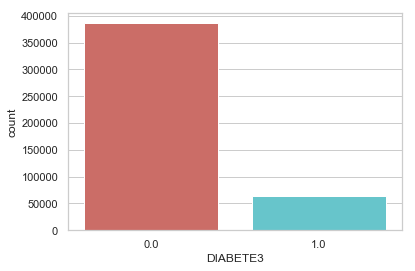

In [71]:
#Plot showing that Diabetes group frequencies are unbalanced before SMOTe

sns.countplot(x='DIABETE3', data=diabetes_df_2017, palette='hls')
plt.show
plt.savefig('Diabetes_Count_Plot_Before_SMOTe')

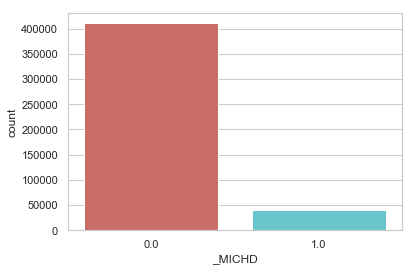

In [72]:
#Plot showing that Heart Disease/Heart Attack group frequencies are unbalanced before SMOTe

sns.countplot(x='_MICHD', data=heart_disease_attack_df_2017, palette='hls')
plt.show
plt.savefig('HeartDiseaseAttack_Count_Plot_Before_SMOTe')

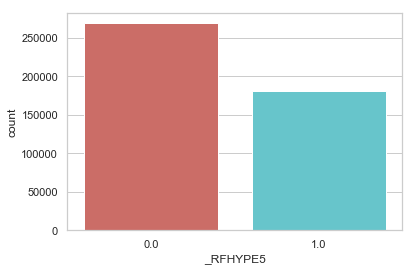

In [73]:
#Plot showing that Hypertension group frequencies are unbalanced before SMOTe

sns.countplot(x='_RFHYPE5', data=hypertension_df_2017, palette='hls')
plt.show
plt.savefig('Hypertension_Count_Plot_Before_SMOTe')

In [341]:
# Applying SMOTe

# Diabetes

diabetes_X = diabetes_df_2017[[col_name for col_name in diabetes_df_2017.columns if col_name != 'DIABETE3']]
diabetes_y = diabetes_df_2017['DIABETE3']

In [342]:
os = SMOTE(random_state=0)

X_train_diabetes, X_test_diabetes, y_train_diabetes, y_test_diabetes = train_test_split(diabetes_X, diabetes_y, test_size=0.3, random_state=0)

diabetes_columns = X_train_diabetes.columns
os_X_diabetes,os_y_diabetes = os.fit_sample(X_train_diabetes, y_train_diabetes)
os_X_diabetes = pd.DataFrame(data = os_X_diabetes, columns = diabetes_columns )
os_y_diabetes = pd.DataFrame(data = os_y_diabetes, columns=['DIABETE3'])

In [255]:
# Prints results of SMOTe - Diabetes

print("Length of oversampled diabetes data is", len(os_X_diabetes))
print("Number of columns in oversampled diabetes data is", os_X_diabetes.shape[1])
print("Number of no diabetes dx in oversampled data", len(os_y_diabetes[os_y_diabetes['DIABETE3'] == 0]))
print("Number of diabetes dx", len(os_y_diabetes[os_y_diabetes['DIABETE3'] == 1]))
print("Proportion of no diabetes dx data in oversampled data is ", len(os_y_diabetes[os_y_diabetes['DIABETE3'] == 0])/len(os_X_diabetes))
print("Proportion of diabetes dx data in oversampled data is ", len(os_y_diabetes[os_y_diabetes['DIABETE3'] == 1])/len(os_X_diabetes))

Length of oversampled diabetes data is 540712
Number of columns in oversampled diabetes data is 522
Number of no diabetes dx in oversampled data 270356
Number of diabetes dx 270356
Proportion of no diabetes dx data in oversampled data is  0.5
Proportion of diabetes dx data in oversampled data is  0.5


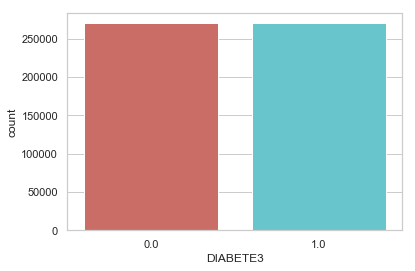

In [256]:
# Plot showing that Diabetes group frequencies are balanced after SMOTe

sns.countplot(x='DIABETE3', data=os_y_diabetes, palette='hls')
plt.show
plt.savefig('Diabetes_Count_Plot_After_SMOTe')

In [343]:
# Heart Disease/Heart Attack

heart_disease_attack_X = heart_disease_attack_df_2017[[col_name for col_name in heart_disease_attack_df_2017.columns if col_name != '_MICHD']]
heart_disease_attack_y = heart_disease_attack_df_2017['_MICHD']

In [344]:
os2 = SMOTE(random_state=0)

X_train_heart, X_test_heart, y_train_heart, y_test_heart = train_test_split(heart_disease_attack_X, heart_disease_attack_y, test_size=0.3, random_state=0)

heart_disease_attack_columns = X_train_heart.columns
os_X_heart,os_y_heart = os2.fit_sample(X_train_heart, y_train_heart)
os_X_heart = pd.DataFrame(data = os_X_heart, columns = heart_disease_attack_columns)
os_y_heart = pd.DataFrame(data = os_y_heart, columns = ['_MICHD'])

In [237]:
# Prints results of SMOTe - Heart Disease/Attack

print("Length of oversampled heart disease/attack data is ", len(os_X_heart))
print("Number of columns in oversampled diabetes data is", os_X_heart.shape[1])
print("Number of no heart diease/attack dx in oversampled data", len(os_y_heart[os_y_heart['_MICHD'] == 0]))
print("Number of heart disease/attack dx", len(os_y_heart[os_y_heart['_MICHD'] == 1]))
print("Proportion of no heart disease/attack dx data in oversampled data is ", len(os_y_heart[os_y_heart['_MICHD'] == 0])/len(os_X_heart))
print("Proportion of heart disease/attack dx data in oversampled data is ", len(os_y_heart[os_y_heart['_MICHD'] == 1])/len(os_X_heart))

Length of oversampled heart disease/attack data is  574900
Number of columns in oversampled diabetes data is 522
Number of no heart diease/attack dx in oversampled data 287450
Number of heart disease/attack dx 287450
Proportion of no heart disease/attack dx data in oversampled data is  0.5
Proportion of heart disease/attack dx data in oversampled data is  0.5


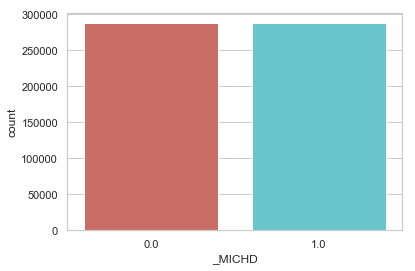

In [238]:
# Plot showing that Heart Disease/Attack group frequencies are balanced after SMOTe

sns.countplot(x='_MICHD', data=os_y_heart, palette='hls')
plt.show
plt.savefig('HeartDiseaseAttack_Count_Plot_After_SMOTe')

In [345]:
# Hypertension

hypertension_X = hypertension_df_2017[[col_name for col_name in hypertension_df_2017.columns if col_name != '_RFHYPE5']]
hypertension_y = hypertension_df_2017['_RFHYPE5']

In [346]:
os3 = SMOTE(random_state=0)

X_train_hypertension, X_test_hypertension, y_train_hypertension, y_test_hypertension = train_test_split(hypertension_X, hypertension_y, test_size=0.3, random_state=0)

hypertension_columns = X_train_hypertension.columns
os_X_hypertension,os_y_hypertension = os.fit_sample(X_train_hypertension, y_train_hypertension)
os_X_hypertension = pd.DataFrame(data = os_X_hypertension, columns = hypertension_columns )
os_y_hypertension = pd.DataFrame(data = os_y_hypertension, columns=['_RFHYPE5'])

In [241]:
# Prints results of SMOTe - Hypertension

print("Length of oversampled hypertension data is ", len(os_X_hypertension))
print("Number of columns in oversampled diabetes data is", os_X_hypertension.shape[1])
print("Number of no hypertension dx in oversampled data", len(os_y_hypertension[os_y_hypertension['_RFHYPE5'] == 0]))
print("Number of hypertension dx", len(os_y_hypertension[os_y_hypertension['_RFHYPE5'] == 1]))
print("Proportion of no hypertension dx data in oversampled data is ", len(os_y_hypertension[os_y_hypertension['_RFHYPE5'] == 0])/len(os_X_hypertension))
print("Proportion of hypertension dx data in oversampled data is ", len(os_y_hypertension[os_y_hypertension['_RFHYPE5'] == 1])/len(os_X_hypertension))

Length of oversampled hypertension data is  376392
Number of columns in oversampled diabetes data is 521
Number of no hypertension dx in oversampled data 188196
Number of hypertension dx 188196
Proportion of no hypertension dx data in oversampled data is  0.5
Proportion of hypertension dx data in oversampled data is  0.5


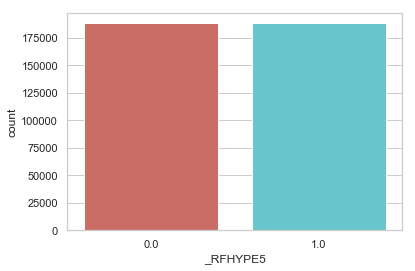

In [242]:
# Plot showing that Hypertension group frequencies are balanced after SMOTe

sns.countplot(x='_RFHYPE5', data=os_y_hypertension, palette='hls')
plt.show
plt.savefig('Hypertension_Count_Plot_After_SMOTe')

<b>Part 1G: Standardize continuous predictors:

In [257]:
# Creating dataframes of the standardized, continuous variables only
# Standardizing X_train and X_test for each disease dataframe

# Diabetes

diabetes_cols_to_standardize = [col_name for col_name in os_X_diabetes.columns if col_name in countinuous_features_17]

In [307]:
scaler_train = preprocessing.StandardScaler()
diabetes_scaled_X_train = scaler_train.fit_transform(os_X_diabetes[diabetes_cols_to_standardize])
diabetes_scaled_df_X_train = pd.DataFrame(diabetes_scaled_X_train, columns=diabetes_cols_to_standardize, index=os_X_diabetes.index)

In [308]:
scaler_test = preprocessing.StandardScaler()
diabetes_scaled_X_test = scaler_test.fit_transform(X_test_diabetes[diabetes_cols_to_standardize])
diabetes_scaled_df_X_test = pd.DataFrame(diabetes_scaled_X_test, columns=diabetes_cols_to_standardize, index=X_test_diabetes.index)

In [310]:
# View on Diabetes standardized dataframes

diabetes_scaled_df_X_train.head()

,NUMADULT,NUMMEN,NUMWOMEN,HHADULT,PHYSHLTH,MENTHLTH,POORHLTH,CHILDREN,DRNK3GE5,MAXDRNKS,...,PAFREQ2_,_MINAC11,_MINAC21,STRFREQ_,PAMIN11_,PAMIN21_,PA1MIN_,PAVIG11_,PAVIG21_,PA1VIGM_
0,0.239580,0.271672,0.038185,-0.078883,-0.412726,2.083042,-0.090665,-0.457995,-0.180634,-0.371271,...,-0.396751,0.422779,0.081755,-0.461431,0.174773,-0.011084,0.108908,-0.253613,-0.171797,-0.285183
1,0.239580,0.271672,0.038185,1.465644,-0.628638,3.379311,2.128224,1.718230,-0.180634,0.083050,...,-0.219681,0.250380,-0.237674,-0.122131,0.526441,-0.236915,0.197554,0.804137,-0.171797,0.455363
2,2.122326,2.653157,0.038185,-0.078883,-0.412726,-0.509498,-0.482234,-0.457995,-0.180634,-0.371271,...,2.192715,0.250380,0.218653,2.931571,0.526441,0.408318,0.611238,0.804137,0.616268,0.949060
3,-1.643167,-2.109812,0.038185,-0.078883,2.610046,-0.509498,3.433453,0.630118,-0.180634,-0.371271,...,-0.219681,-0.445847,-0.237674,-0.461431,-0.408372,-0.236915,-0.422971,-0.253613,-0.171797,-0.285183
4,-1.643167,-2.109812,0.038185,-0.078883,-0.628638,-0.509498,-0.482234,-0.457995,-0.180634,-0.371271,...,-0.219681,-0.445847,-0.237674,-0.461431,-0.408372,-0.236915,-0.422971,-0.253613,-0.171797,-0.285183


In [311]:
diabetes_scaled_df_X_test.head()

,NUMADULT,NUMMEN,NUMWOMEN,HHADULT,PHYSHLTH,MENTHLTH,POORHLTH,CHILDREN,DRNK3GE5,MAXDRNKS,...,PAFREQ2_,_MINAC11,_MINAC21,STRFREQ_,PAMIN11_,PAMIN21_,PA1MIN_,PAVIG11_,PAVIG21_,PA1VIGM_
63205,0.196005,0.221056,0.032129,-0.092653,-0.489325,-0.449559,-0.380048,3.392356,-0.204189,-0.414822,...,-0.230059,0.066080,-0.265828,-0.510207,-0.048119,-0.279088,-0.193663,-0.237113,-0.205763,-0.297649
153317,0.196005,0.221056,0.032129,-0.092653,2.911358,-0.449559,-0.380048,-0.495660,-0.204189,-0.414822,...,-0.230059,-0.396371,-0.265828,-0.510207,-0.380168,-0.279088,-0.442049,-0.237113,-0.205763,-0.297649
209908,0.196005,0.221056,0.032129,-0.092653,0.304168,1.325720,0.588401,-0.495660,-0.204189,-0.414822,...,-0.230059,-0.396371,-0.265828,-0.510207,-0.380168,-0.279088,-0.442049,-0.237113,-0.205763,-0.297649
60268,0.196005,0.221056,0.032129,1.258168,0.190812,-0.449559,0.035001,-0.495660,-0.204189,-0.414822,...,0.707573,-0.396371,0.311587,0.403819,-0.380168,0.160581,-0.193663,-0.237113,-0.205763,-0.297649
119979,0.196005,0.221056,0.032129,-0.092653,2.911358,-0.449559,-0.380048,1.448348,-0.204189,-0.414822,...,1.020274,-0.036686,-0.265828,1.622672,-0.121908,-0.279088,-0.248860,-0.237113,-0.205763,-0.297649


In [297]:
# Drop unstandardized versions of continuous features for X train and X test dataframes

os_X_diabetes_drop = os_X_diabetes.drop(columns = diabetes_cols_to_standardize)
X_test_diabetes_drop = X_test_diabetes.drop(columns = diabetes_cols_to_standardize)

In [298]:
# Join standardized versions of continuous features

diabetes_scaled_df_X_train_final = os_X_diabetes_drop.join(diabetes_scaled_df_X_train)
diabetes_scaled_df_X_test_final = X_test_diabetes_drop.join(diabetes_scaled_df_X_test)

In [315]:
# View on final X train and X test datasets - dummy coded & standardized

print(diabetes_scaled_df_X_train_final.shape)
#print(diabetes_scaled_df_X_train_final.isna().sum())
diabetes_scaled_df_X_train_final.head()

(540712, 522)


,CTELENM1,STATERE1,CTELNUM1,CELLFON5,CVDSTRK3,CHCSCNCR,CHCOCNCR,CHCCOPD1,ADDEPEV2,CHCKIDNY,...,PAFREQ2_,_MINAC11,_MINAC21,STRFREQ_,PAMIN11_,PAMIN21_,PA1MIN_,PAVIG11_,PAVIG21_,PA1VIGM_
0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.396751,0.422779,0.081755,-0.461431,0.174773,-0.011084,0.108908,-0.253613,-0.171797,-0.285183
1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.219681,0.250380,-0.237674,-0.122131,0.526441,-0.236915,0.197554,0.804137,-0.171797,0.455363
2,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,2.192715,0.250380,0.218653,2.931571,0.526441,0.408318,0.611238,0.804137,0.616268,0.949060
3,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.219681,-0.445847,-0.237674,-0.461431,-0.408372,-0.236915,-0.422971,-0.253613,-0.171797,-0.285183
4,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.219681,-0.445847,-0.237674,-0.461431,-0.408372,-0.236915,-0.422971,-0.253613,-0.171797,-0.285183


In [314]:
print(diabetes_scaled_df_X_test_final.shape)
#print(diabetes_scaled_df_X_test_final.isna().sum())
diabetes_scaled_df_X_test_final.head()

(135005, 522)


,CTELENM1,STATERE1,CTELNUM1,CELLFON5,CVDSTRK3,CHCSCNCR,CHCOCNCR,CHCCOPD1,ADDEPEV2,CHCKIDNY,...,PAFREQ2_,_MINAC11,_MINAC21,STRFREQ_,PAMIN11_,PAMIN21_,PA1MIN_,PAVIG11_,PAVIG21_,PA1VIGM_
63205,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.230059,0.066080,-0.265828,-0.510207,-0.048119,-0.279088,-0.193663,-0.237113,-0.205763,-0.297649
153317,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,-0.230059,-0.396371,-0.265828,-0.510207,-0.380168,-0.279088,-0.442049,-0.237113,-0.205763,-0.297649
209908,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.230059,-0.396371,-0.265828,-0.510207,-0.380168,-0.279088,-0.442049,-0.237113,-0.205763,-0.297649
60268,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.707573,-0.396371,0.311587,0.403819,-0.380168,0.160581,-0.193663,-0.237113,-0.205763,-0.297649
119979,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.020274,-0.036686,-0.265828,1.622672,-0.121908,-0.279088,-0.248860,-0.237113,-0.205763,-0.297649


In [316]:
# Hypertension

hypertension_cols_to_standardize = [col_name for col_name in os_X_hypertension.columns if col_name in countinuous_features_17]

scaler_train = preprocessing.StandardScaler()
hypertension_scaled_X_train = scaler_train.fit_transform(os_X_hypertension[hypertension_cols_to_standardize])
hypertension_scaled_df_X_train = pd.DataFrame(hypertension_scaled_X_train, columns=hypertension_cols_to_standardize, index=os_X_hypertension.index)

scaler_test = preprocessing.StandardScaler()
hypertension_scaled_X_test = scaler_test.fit_transform(X_test_hypertension[hypertension_cols_to_standardize])
hypertension_scaled_df_X_test = pd.DataFrame(hypertension_scaled_X_test, columns=hypertension_cols_to_standardize, index=X_test_hypertension.index)

In [317]:
# View on Hypertension standardized dataframes

hypertension_scaled_df_X_train.head()

,NUMADULT,NUMMEN,NUMWOMEN,HHADULT,PHYSHLTH,MENTHLTH,POORHLTH,CHILDREN,DRNK3GE5,MAXDRNKS,...,PAFREQ2_,_MINAC11,_MINAC21,STRFREQ_,PAMIN11_,PAMIN21_,PA1MIN_,PAVIG11_,PAVIG21_,PA1VIGM_
0,0.213470,0.242765,0.033966,-0.084923,-0.295156,2.129153,0.008536,-0.473809,-0.203588,-0.415286,...,-0.397997,0.340852,0.055056,-0.498281,0.122166,-0.030886,0.063706,-0.251007,-0.174378,-0.287073
1,0.213470,0.242765,0.033966,1.343546,-0.522346,3.425834,2.353060,1.545861,-0.203588,-0.013595,...,-0.226111,0.183302,-0.249146,-0.172802,0.445008,-0.247397,0.147148,0.718013,-0.174378,0.406465
2,2.084743,2.614122,0.033966,-0.084923,-0.295156,-0.464211,-0.405203,-0.473809,-0.203588,-0.415286,...,2.115670,0.183302,0.185428,2.756505,0.445008,0.371207,0.536545,0.718013,0.576150,0.868824
3,-1.657803,-2.128593,0.033966,-0.084923,2.885508,-0.464211,3.732191,0.536026,-0.203588,-0.415286,...,-0.226111,-0.452958,-0.249146,-0.498281,-0.413180,-0.247397,-0.436947,-0.251007,-0.174378,-0.287073
4,-1.657803,-2.128593,0.033966,-0.084923,-0.522346,-0.464211,-0.405203,-0.473809,-0.203588,-0.415286,...,-0.226111,-0.452958,-0.249146,-0.498281,-0.413180,-0.247397,-0.436947,-0.251007,-0.174378,-0.287073


In [318]:
hypertension_scaled_df_X_test.head()

,NUMADULT,NUMMEN,NUMWOMEN,HHADULT,PHYSHLTH,MENTHLTH,POORHLTH,CHILDREN,DRNK3GE5,MAXDRNKS,...,PAFREQ2_,_MINAC11,_MINAC21,STRFREQ_,PAMIN11_,PAMIN21_,PA1MIN_,PAVIG11_,PAVIG21_,PA1VIGM_
63205,0.196005,0.221056,0.032129,-0.092653,-0.489325,-0.449559,-0.380048,3.392356,-0.204189,-0.414822,...,-0.230059,0.066080,-0.265828,-0.510207,-0.048119,-0.279088,-0.193663,-0.237113,-0.205763,-0.297649
153317,0.196005,0.221056,0.032129,-0.092653,2.911358,-0.449559,-0.380048,-0.495660,-0.204189,-0.414822,...,-0.230059,-0.396371,-0.265828,-0.510207,-0.380168,-0.279088,-0.442049,-0.237113,-0.205763,-0.297649
209908,0.196005,0.221056,0.032129,-0.092653,0.304168,1.325720,0.588401,-0.495660,-0.204189,-0.414822,...,-0.230059,-0.396371,-0.265828,-0.510207,-0.380168,-0.279088,-0.442049,-0.237113,-0.205763,-0.297649
60268,0.196005,0.221056,0.032129,1.258168,0.190812,-0.449559,0.035001,-0.495660,-0.204189,-0.414822,...,0.707573,-0.396371,0.311587,0.403819,-0.380168,0.160581,-0.193663,-0.237113,-0.205763,-0.297649
119979,0.196005,0.221056,0.032129,-0.092653,2.911358,-0.449559,-0.380048,1.448348,-0.204189,-0.414822,...,1.020274,-0.036686,-0.265828,1.622672,-0.121908,-0.279088,-0.248860,-0.237113,-0.205763,-0.297649


In [322]:
# Drop unstandardized versions of continuous features for X train and X test dataframes

os_X_hypertension_drop = os_X_hypertension.drop(columns = hypertension_cols_to_standardize)
X_test_hypertension_drop = X_test_hypertension.drop(columns = hypertension_cols_to_standardize)

In [323]:
# Join standardized versions of continuous features

hypertension_scaled_df_X_train_final = os_X_hypertension_drop.join(hypertension_scaled_df_X_train)
hypertension_scaled_df_X_test_final = X_test_hypertension_drop.join(hypertension_scaled_df_X_test)

In [327]:
# View on final X train and X test datasets - dummy coded & standardized

print(hypertension_scaled_df_X_train_final.shape)
#print(hypertension_scaled_df_X_train_final.isna().sum())
hypertension_scaled_df_X_train_final.head()

(376392, 521)


,CTELENM1,STATERE1,CTELNUM1,CELLFON5,CVDSTRK3,CHCSCNCR,CHCOCNCR,CHCCOPD1,ADDEPEV2,CHCKIDNY,...,PAFREQ2_,_MINAC11,_MINAC21,STRFREQ_,PAMIN11_,PAMIN21_,PA1MIN_,PAVIG11_,PAVIG21_,PA1VIGM_
0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.397997,0.340852,0.055056,-0.498281,0.122166,-0.030886,0.063706,-0.251007,-0.174378,-0.287073
1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.226111,0.183302,-0.249146,-0.172802,0.445008,-0.247397,0.147148,0.718013,-0.174378,0.406465
2,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,2.115670,0.183302,0.185428,2.756505,0.445008,0.371207,0.536545,0.718013,0.576150,0.868824
3,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.226111,-0.452958,-0.249146,-0.498281,-0.413180,-0.247397,-0.436947,-0.251007,-0.174378,-0.287073
4,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.226111,-0.452958,-0.249146,-0.498281,-0.413180,-0.247397,-0.436947,-0.251007,-0.174378,-0.287073


In [329]:
print(hypertension_scaled_df_X_test_final.shape)
#print(hypertension_scaled_df_X_test_final.isna().sum())
hypertension_scaled_df_X_test_final.head()

(135005, 521)


,CTELENM1,STATERE1,CTELNUM1,CELLFON5,CVDSTRK3,CHCSCNCR,CHCOCNCR,CHCCOPD1,ADDEPEV2,CHCKIDNY,...,PAFREQ2_,_MINAC11,_MINAC21,STRFREQ_,PAMIN11_,PAMIN21_,PA1MIN_,PAVIG11_,PAVIG21_,PA1VIGM_
63205,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.230059,0.066080,-0.265828,-0.510207,-0.048119,-0.279088,-0.193663,-0.237113,-0.205763,-0.297649
153317,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,-0.230059,-0.396371,-0.265828,-0.510207,-0.380168,-0.279088,-0.442049,-0.237113,-0.205763,-0.297649
209908,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.230059,-0.396371,-0.265828,-0.510207,-0.380168,-0.279088,-0.442049,-0.237113,-0.205763,-0.297649
60268,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.707573,-0.396371,0.311587,0.403819,-0.380168,0.160581,-0.193663,-0.237113,-0.205763,-0.297649
119979,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.020274,-0.036686,-0.265828,1.622672,-0.121908,-0.279088,-0.248860,-0.237113,-0.205763,-0.297649


In [330]:
# Heart Disease/Attack

heart_cols_to_standardize = [col_name for col_name in os_X_heart.columns if col_name in countinuous_features_17]

scaler_train = preprocessing.StandardScaler()
heart_scaled_X_train = scaler_train.fit_transform(os_X_heart[heart_cols_to_standardize])
heart_scaled_df_X_train = pd.DataFrame(heart_scaled_X_train, columns=heart_cols_to_standardize, index=os_X_heart.index)

scaler_test = preprocessing.StandardScaler()
heart_scaled_X_test = scaler_test.fit_transform(X_test_heart[heart_cols_to_standardize])
heart_scaled_df_X_test = pd.DataFrame(heart_scaled_X_test, columns=heart_cols_to_standardize, index=X_test_heart.index)

In [331]:
# View on Hypertension standardized dataframes

heart_scaled_df_X_train.head()

,NUMADULT,NUMMEN,NUMWOMEN,HHADULT,PHYSHLTH,MENTHLTH,POORHLTH,CHILDREN,DRNK3GE5,MAXDRNKS,...,PAFREQ2_,_MINAC11,_MINAC21,STRFREQ_,PAMIN11_,PAMIN21_,PA1MIN_,PAVIG11_,PAVIG21_,PA1VIGM_
0,0.269311,0.273869,0.085981,-0.056818,-0.473336,2.011979,-0.155505,-0.406738,-0.181731,-0.374786,...,-0.406148,0.385478,0.078189,-0.469827,0.136135,-0.027178,0.075181,-0.280466,-0.190263,-0.313216
1,0.269311,0.273869,0.085981,1.522208,-0.678868,3.278965,1.932805,1.854720,-0.181731,0.070129,...,-0.229223,0.221934,-0.252176,-0.135063,0.467820,-0.250775,0.160393,0.717252,-0.190263,0.380778
2,2.123414,2.678065,0.085981,-0.056818,-0.473336,-0.521991,-0.524030,-0.406738,-0.181731,-0.374786,...,2.181192,0.221934,0.219774,2.877810,0.467820,0.388073,0.558048,0.717252,0.554917,0.843440
3,-1.584792,-2.130327,0.085981,-0.056818,2.404113,-0.521991,3.161222,0.723991,-0.181731,-0.374786,...,-0.229223,-0.438534,-0.252176,-0.469827,-0.413873,-0.250775,-0.436090,-0.280466,-0.190263,-0.313216
4,-1.584792,-2.130327,0.085981,-0.056818,-0.678868,-0.521991,-0.524030,-0.406738,-0.181731,-0.374786,...,-0.229223,-0.438534,-0.252176,-0.469827,-0.413873,-0.250775,-0.436090,-0.280466,-0.190263,-0.313216


In [332]:
hypertension_scaled_df_X_test.head()

,NUMADULT,NUMMEN,NUMWOMEN,HHADULT,PHYSHLTH,MENTHLTH,POORHLTH,CHILDREN,DRNK3GE5,MAXDRNKS,...,PAFREQ2_,_MINAC11,_MINAC21,STRFREQ_,PAMIN11_,PAMIN21_,PA1MIN_,PAVIG11_,PAVIG21_,PA1VIGM_
63205,0.196005,0.221056,0.032129,-0.092653,-0.489325,-0.449559,-0.380048,3.392356,-0.204189,-0.414822,...,-0.230059,0.066080,-0.265828,-0.510207,-0.048119,-0.279088,-0.193663,-0.237113,-0.205763,-0.297649
153317,0.196005,0.221056,0.032129,-0.092653,2.911358,-0.449559,-0.380048,-0.495660,-0.204189,-0.414822,...,-0.230059,-0.396371,-0.265828,-0.510207,-0.380168,-0.279088,-0.442049,-0.237113,-0.205763,-0.297649
209908,0.196005,0.221056,0.032129,-0.092653,0.304168,1.325720,0.588401,-0.495660,-0.204189,-0.414822,...,-0.230059,-0.396371,-0.265828,-0.510207,-0.380168,-0.279088,-0.442049,-0.237113,-0.205763,-0.297649
60268,0.196005,0.221056,0.032129,1.258168,0.190812,-0.449559,0.035001,-0.495660,-0.204189,-0.414822,...,0.707573,-0.396371,0.311587,0.403819,-0.380168,0.160581,-0.193663,-0.237113,-0.205763,-0.297649
119979,0.196005,0.221056,0.032129,-0.092653,2.911358,-0.449559,-0.380048,1.448348,-0.204189,-0.414822,...,1.020274,-0.036686,-0.265828,1.622672,-0.121908,-0.279088,-0.248860,-0.237113,-0.205763,-0.297649


In [333]:
# Drop unstandardized versions of continuous features for X train and X test dataframes

os_X_heart_drop = os_X_heart.drop(columns = heart_cols_to_standardize)
X_test_heart_drop = X_test_heart.drop(columns = heart_cols_to_standardize)

In [334]:
# Join standardized versions of continuous features

heart_scaled_df_X_train_final = os_X_heart_drop.join(heart_scaled_df_X_train)
heart_scaled_df_X_test_final = X_test_heart_drop.join(heart_scaled_df_X_test)

In [336]:
# View on final X train and X test datasets - dummy coded & standardized

print(heart_scaled_df_X_test_final.shape)
#print(heart_scaled_df_X_test_final.isna().sum())
heart_scaled_df_X_train_final.head()

(135005, 522)


,CTELENM1,STATERE1,CTELNUM1,CELLFON5,CVDSTRK3,CHCSCNCR,CHCOCNCR,CHCCOPD1,ADDEPEV2,CHCKIDNY,...,PAFREQ2_,_MINAC11,_MINAC21,STRFREQ_,PAMIN11_,PAMIN21_,PA1MIN_,PAVIG11_,PAVIG21_,PA1VIGM_
0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.406148,0.385478,0.078189,-0.469827,0.136135,-0.027178,0.075181,-0.280466,-0.190263,-0.313216
1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.229223,0.221934,-0.252176,-0.135063,0.467820,-0.250775,0.160393,0.717252,-0.190263,0.380778
2,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,2.181192,0.221934,0.219774,2.877810,0.467820,0.388073,0.558048,0.717252,0.554917,0.843440
3,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.229223,-0.438534,-0.252176,-0.469827,-0.413873,-0.250775,-0.436090,-0.280466,-0.190263,-0.313216
4,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.229223,-0.438534,-0.252176,-0.469827,-0.413873,-0.250775,-0.436090,-0.280466,-0.190263,-0.313216


In [338]:
print(heart_scaled_df_X_train_final.shape)
#print(heart_scaled_df_X_train_final.isna().sum())
heart_scaled_df_X_train_final.head()

(574900, 522)


,CTELENM1,STATERE1,CTELNUM1,CELLFON5,CVDSTRK3,CHCSCNCR,CHCOCNCR,CHCCOPD1,ADDEPEV2,CHCKIDNY,...,PAFREQ2_,_MINAC11,_MINAC21,STRFREQ_,PAMIN11_,PAMIN21_,PA1MIN_,PAVIG11_,PAVIG21_,PA1VIGM_
0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.406148,0.385478,0.078189,-0.469827,0.136135,-0.027178,0.075181,-0.280466,-0.190263,-0.313216
1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.229223,0.221934,-0.252176,-0.135063,0.467820,-0.250775,0.160393,0.717252,-0.190263,0.380778
2,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,2.181192,0.221934,0.219774,2.877810,0.467820,0.388073,0.558048,0.717252,0.554917,0.843440
3,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.229223,-0.438534,-0.252176,-0.469827,-0.413873,-0.250775,-0.436090,-0.280466,-0.190263,-0.313216
4,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.229223,-0.438534,-0.252176,-0.469827,-0.413873,-0.250775,-0.436090,-0.280466,-0.190263,-0.313216


<b> Part 1H: Pickle Fully Preprocessed Dataframes</b>

In [347]:
#Pickling Diabetes dataframes

diabetes_scaled_df_X_train_final.to_pickle("./os_X_diabetes.pkl")
os_y_diabetes.to_pickle("./os_y_diabetes.pkl")
diabetes_scaled_df_X_test_final.to_pickle("./X_test_diabetes.pkl")
y_test_diabetes.to_pickle("./y_test_diabetes.pkl")

In [348]:
#Pickling Heart Disease/Heart Attack dataframes

heart_scaled_df_X_train_final.to_pickle("./os_X_heart.pkl")
os_y_heart.to_pickle("./os_y_heart.pkl")
heart_scaled_df_X_test_final.to_pickle("./X_test_heart.pkl")
y_test_heart.to_pickle("./y_test_heart.pkl")

In [349]:
#Pickling Hypertension dataframes

hypertension_scaled_df_X_train_final.to_pickle("./os_X_hypertension.pkl")
os_y_hypertension.to_pickle("./os_y_hypertension.pkl")
hypertension_scaled_df_X_test_final.to_pickle("./X_test_hypertension.pkl")
y_test_hypertension.to_pickle("./y_test_hypertension.pkl")

<b> Preprocessed Dataframes for Modeling by Outcome (2017):</b>
    
The following dataframes should be used for modeling:
- Diabetes: <i>Train</i> = os_X_diabetes, os_y_diabetes; <i>Test</i> = X_test_diabetes, y_test_diabetes
- Heart Disease/Heart Attack: <i>Train</i> = os_X_heart, os_y_heart; <i>Test</i> = X_test_heart, y_test_heart
- Hypertension:<i>Train</i> = os_X_hypertension, os_y_hypertension; <i>Test</i> = X_test_hypertension, y_test_hypertension

Pickled versions of these dataframes are provided. To unpickle, run the code below:

In [350]:
#Unpickling Diabetes dataframes

unpick_os_X_diabetes = pd.read_pickle("./os_X_diabetes.pkl")
unpick_os_y_diabetes = pd.read_pickle("./os_y_diabetes.pkl")
unpick_X_test_diabetes = pd.read_pickle("./X_test_diabetes.pkl")
unpick_y_test_diabetes = pd.read_pickle("./y_test_diabetes.pkl")

In [351]:
#Unpickling Heart Disease/Heart Attack dataframes

unpick_os_X_heart = pd.read_pickle("./os_X_heart.pkl")
unpick_os_y_heart = pd.read_pickle("./os_y_heart.pkl")
unpick_X_test_heart = pd.read_pickle("./X_test_heart.pkl")
unpick_y_test_heart = pd.read_pickle("./y_test_heart.pkl")

In [352]:
#Unpickling Hypertension dataframes

unpick_os_X_hypertension = pd.read_pickle("./os_X_hypertension.pkl")
unpick_os_y_hypertension = pd.read_pickle("./os_y_hypertension.pkl")
unpick_X_test_hypertension = pd.read_pickle("./X_test_hypertension.pkl")
unpick_y_test_hypertension = pd.read_pickle("./y_test_hypertension.pkl")